# Evaluating Tool-Use Errors with Limbic

This notebook evaluates how agents use tools, using the Limbic evaluator.  
It runs models on a compact dataset of tool-use tasks, checks their outputs against ground truth,  
and analyzes error patterns across categories (incorrect tool, incorrect parameter names, incorrect parameter values).  


## Setup  

We install required libraries and set up API keys for running models.  
- `together` for calling Kimi K2 and Qwen  
- Standard Python libraries for JSON handling and plotting

In [ ]:
!pip install --upgrade together

In [2]:
import os
import json
import time
from typing import Dict, List, Any, Optional
import requests
import pandas as pd
from datetime import datetime
import random
from collections import defaultdict

import openai
from together import Together

In [ ]:
os.environ['TOGETHER_API_KEY'] = "your_together_api_key"

In [8]:
import json
import ast
from datasets import load_dataset

# Load the dataset
dataset = load_dataset("quotientai/limbic-eval-tool-use-mcp")

# Get first example
first_example = dataset['test'][0]

# Parse the string representations to actual Python objects
available_tools = ast.literal_eval(first_example['available_tools'])
message_history = ast.literal_eval(first_example['message_history'])

print("Dataset Overview:")
print(f"Total examples: {len(dataset['test'])}")
print(f"Fields: {list(first_example.keys())}")

print("\n" + "="*60)
print("First Example Details:")
print("="*60)

# Available tools
print(f"\nAvailable tools: {len(available_tools)} tools")
if available_tools:
    # Parse the first tool if it's a string
    first_tool = available_tools[0]
    if isinstance(first_tool, str):
        first_tool = ast.literal_eval(first_tool)
    print("Sample tool:")
    print(json.dumps(first_tool, indent=2)[:500] + "...")

# Message history
print(f"\nMessage history: {len(message_history)} messages")
for i, msg in enumerate(message_history):
    if isinstance(msg, str):
        msg = ast.literal_eval(msg)
    print(f"Message {i+1} - Role: {msg.get('role', 'unknown')}")
    if msg.get('role') == 'user':
        print(f"  User request: {msg.get('content', '')[:100]}...")
    elif msg.get('role') == 'assistant' and 'content' in msg:
        if isinstance(msg['content'], list) and len(msg['content']) > 0:
            tool_call = msg['content'][0]
            print(f"  Tool called: {tool_call.get('name', 'unknown')}")

# Score and failure reason
print(f"\nScore: {first_example['score']}")
print(f"Failure reason: {first_example.get('failure_reason', 'None')}")

# Score distribution
print("\n" + "="*60)
print("Score Distribution (full dataset):")
print("="*60)
score_counts = {}
for example in dataset['test']:
    score = example['score']
    score_counts[score] = score_counts.get(score, 0) + 1

for score, count in sorted(score_counts.items()):
    percentage = (count / len(dataset['test'])) * 100
    print(f"{score}: {count} ({percentage:.1f}%)")

# Sample each error type
print("\n" + "="*60)
print("Example of each error type:")
print("="*60)

for score_type in ['correct', 'incorrect_tool', 'incorrect_parameter_names', 'incorrect_parameter_values']:
    for i, example in enumerate(dataset['test']):
        if example['score'] == score_type:
            message_history = ast.literal_eval(example['message_history'])
            user_msg = next((m for m in message_history if isinstance(m, str) and 'user' in m or (isinstance(m, dict) and m.get('role') == 'user')), None)
            if user_msg:
                if isinstance(user_msg, str):
                    user_msg = ast.literal_eval(user_msg)
                print(f"\n{score_type.upper()}:")
                print(f"  User: {user_msg.get('content', '')[:100]}...")
                if example.get('failure_reason'):
                    print(f"  Failure: {example['failure_reason']}")
            break

Dataset Overview:
Total examples: 9813
Fields: ['available_tools', 'message_history', 'score', 'failure_reason']

First Example Details:

Available tools: 1 tools
Sample tool:
{
  "name": "google-play-developer",
  "description": "Get apps by a developer on Google Play",
  "input_schema": {
    "type": "object",
    "properties": {
      "num": {
        "type": "number",
        "default": 60,
        "description": "Number of results (default: 60)"
      },
      "lang": {
        "type": "string",
        "default": "en",
        "description": "Language code (default: en)"
      },
      "devId": {
        "type": "string",
        "description": "Developer ID"
  ...

Message history: 2 messages
Message 1 - Role: user
  User request: I'm looking to evaluate the performance of all the apps developed by 'Example Developer' on the Goog...
Message 2 - Role: assistant
  Tool called: google-play-developer

Score: correct
Failure reason: None

Score Distribution (full dataset):
correct: 4

## Dataset

We use a compact dataset of 15 evaluation cases (`tools_evaluations.jsonl`).  
Each record specifies:  
- A user request in natural language  
- A set of available tool schemas  
- A ground-truth tool call  

The dataset spans test types such as simple correct calls, optional parameters, structured data, and ambiguous mappings.  

In [10]:
import ast, json
from copy import deepcopy

def _safe_eval(x):
    if isinstance(x, (list, dict)):
        return x
    try:
        return ast.literal_eval(x)
    except Exception:
        try:
            return json.loads(x)
        except Exception:
            return x

def _camelize_input_schema(tool):
    t = deepcopy(tool)
    if "input_schema" in t and "inputSchema" not in t:
        t["inputSchema"] = t.pop("input_schema")
    sch = t.get("inputSchema")
    if isinstance(sch, dict) and "properties" in sch:
        for k, v in list(sch["properties"].items()):
            if isinstance(v, str):
                try:
                    sch["properties"][k] = ast.literal_eval(v)
                except Exception:
                    pass
    return t

def _normalize_tools(tools_raw):
    tools = _safe_eval(tools_raw)
    out = []
    for item in tools:
        item = _safe_eval(item)
        out.append(_camelize_input_schema(item))
    return out

def _normalize_messages(msgs_raw):
    msgs = _safe_eval(msgs_raw)
    norm = []
    for m in msgs:
        norm.append(_safe_eval(m))
    return norm

def extract_user_request(message_history):
    msgs = _normalize_messages(message_history)
    for m in msgs:
        if isinstance(m, dict) and m.get("role") == "user":
            return m.get("content", "")
        if isinstance(m, str):
            try:
                d = ast.literal_eval(m)
                if isinstance(d, dict) and d.get("role") == "user":
                    return d.get("content", "")
            except Exception:
                pass
    return ""

def _strip_to_user_ctx(messages):
    ctx = []
    for m in _normalize_messages(messages):
        if isinstance(m, dict) and m.get("role") in ("system", "user"):
            ctx.append(m)
    return ctx

def _extract_assistant_tool_call(messages):
    msgs = _normalize_messages(messages)
    for m in msgs:
        if m.get("role") != "assistant":
            continue
        c = m.get("content")
        if isinstance(c, list) and c:
            tc = c[0]
            if isinstance(tc, str):
                try: tc = ast.literal_eval(tc)
                except Exception: pass
            if isinstance(tc, dict):
                name = tc.get("name")
                params = tc.get("input", tc.get("parameters"))
                if name and isinstance(params, dict):
                    return {"name": name, "parameters": params}
    return None


In [12]:
from datasets import load_dataset

# Config
RAND_SEED = 17
SAMPLE_SIZE = 1000

# Load
hf = load_dataset("quotientai/limbic-eval-tool-use-mcp")
full = hf["test"]

# Sample exactly 1000 deterministically (or fewer if dataset smaller)
sampled = full.shuffle(seed=RAND_SEED).select(range(min(SAMPLE_SIZE, len(full))))

records = []

for ex in sampled:
    tools = _normalize_tools(ex["available_tools"])
    msgs_full = _normalize_messages(ex["message_history"])
    user_ctx = _strip_to_user_ctx(ex["message_history"])
    assistant_tc = _extract_assistant_tool_call(ex["message_history"])
    user_request = extract_user_request(ex["message_history"])

    records.append({
        "available_tools": tools,
        "message_history_user_ctx": user_ctx,
        "assistant_tool_call_in_dataset": assistant_tc,
        "label_score": ex.get("score"),
        "failure_reason": ex.get("failure_reason"),
        "user_request": user_request,
    })

In [14]:
records[3]

{'available_tools': [{'type': 'function',
   'function': {'name': 'discord_delete_webhook',
    'description': 'Deletes an existing webhook for a Discord channel',
    'parameters': {'type': 'object',
     'properties': {'reason': {'type': 'string'},
      'webhookId': {'type': 'string'},
      'webhookToken': {'type': 'string'}},
     'required': ['webhookId']}}}],
 'message_history_user_ctx': [{'role': 'user',
   'content': "I want to clean up my Discord server and remove the webhook that I set up for sending marketing updates. The webhook is no longer necessary, and I want to make sure it's deleted properly."}],
 'assistant_tool_call_in_dataset': None,
 'label_score': 'incorrect_tool',
 'failure_reason': "['hallucinated function name']",
 'user_request': "I want to clean up my Discord server and remove the webhook that I set up for sending marketing updates. The webhook is no longer necessary, and I want to make sure it's deleted properly."}

In [15]:
len(records)

1000

## Formatting tool calls for TogetherAI

In [16]:
def call_together_api(
    messages: list,
    model: str,
    tools: Optional[list] = None,
    temperature: float = 0.6
) -> Dict[str, Any]:
    client = Together()

    params = {
        "model": model,
        "messages": messages,
        "temperature": temperature,
    }
    if tools:
        params["tools"] = tools
        params["tool_choice"] = "auto"

    try:
        response = client.chat.completions.create(**params)

        tool_calls = []
        if response.choices[0].message.tool_calls:
            for tc in response.choices[0].message.tool_calls:
                tool_calls.append({
                    "type": "tool_use",
                    "id": tc.id,
                    "name": tc.function.name,
                    "parameters": json.loads(tc.function.arguments)
                })

        return {
            "success": True,
            "messages": messages + [{"role": "assistant", "content": tool_calls if tool_calls else None}],
            "prediction": tool_calls[0] if tool_calls else None,
        }
    except Exception as e:
        return {"success": False, "error": str(e)}

## Evaluating with Limbic

Limbic inspects each tool call and assigns one of four labels:  
- correct  
- incorrect_tool  
- incorrect_parameter_names  
- incorrect_parameter_values  

This gives us structured judgments instead of raw pass/fail results.  

In [18]:
# Limbic Evaluation
def get_tool_call_eval(messages: List[dict], available_tools: List[dict]) -> Dict[str, Any]:
    """Limbic API evaluation function"""
    payload = {
        "messages": messages,
        "available_tools": available_tools
    }

    url = "https://quotient-ai--tool-call-evaluator-7b-api-v0-fastapi-app.modal.run/api/v1/detections/tool-use"
    try:
        response = requests.post(url, json=payload, timeout=120)
        if response.status_code == 200:
            result = response.json()
            return {
                "success": True,
                "status_code": response.status_code,
                "score": result["score"],
                "reasoning": result["reasoning"],
            }
        else:
            return {
                "success": False,
                "status_code": response.status_code,
                "error": response.text,
            }
    except Exception as e:
        return {
            "success": False,
            "error": str(e),
        }

## Run Models

We run two models (Kimi K2, Qwen) on each test case.  
Their outputs are captured as tool calls, which are then passed into Limbic for evaluation. 

In [ ]:
from collections import Counter
import json, time

PRINT_LIMIT = 10            # show at most 10 examples
SLEEP_BETWEEN_CALLS = 0.05

# Initialize models configuration
models = [
    {
        "name": "Kimi K2",
        "model": "moonshotai/Kimi-K2-Instruct"
    },
    {
        "name": "Qwen",
        "model": "Qwen/Qwen3-235B-A22B-Instruct-2507-tput"
    }
]

# Initialize score tracking
score_categories = [
    "correct",
    "incorrect_tool",
    "incorrect_parameter_names",
    "incorrect_parameter_values"
]

# Store detailed results
detailed_results = []

# Track metrics per model: label counts (if judge returns labels) + numeric score stats (if judge returns float)
metrics = {
    m["name"]: {"labels": Counter(), "n": 0, "score_sum": 0.0, "errors": 0}
    for m in models
}

# Store detailed results
detailed_results = []

# Use your prebuilt 1,000-record sample directly
random_subset = records
total_examples = len(random_subset)

print(f"Processing {total_examples} random examples...")
print("-" * 50)

for i, entry in enumerate(random_subset, 1):
    show = i <= PRINT_LIMIT

    # Pull messages & tools from the normalized record
    messages = entry["message_history_user_ctx"]
    tools = entry["available_tools"]
    user_prompt_preview = entry.get("user_request", "")[:100]

    if show:
        print(f"\nExample {i}:")
        print(f"User Prompt: {user_prompt_preview}...")

    for model_cfg in models:
        model_name = model_cfg["name"]
        model_id = model_cfg["model"]

        if show:
            print(f"\n{model_name} Response:")

        try:
            # Call model on this example
            result = call_together_api(messages=messages, model=model_id, tools=tools)

            prediction = None
            msgs_for_eval = messages
            if result.get("success"):
                # Prefer the messages returned by the model (they may include the assistant's tool call)
                msgs_for_eval = result.get("messages", messages)
                prediction = result.get("prediction")  # {"name":..., "parameters":{...}} or None

            # Pretty-print (only for the first PRINT_LIMIT)
            if show:
                if prediction is None:
                    print("NO_TOOL_CALLED")
                else:
                    print(json.dumps({
                        "name": prediction.get("name"),
                        "parameters": prediction.get("parameters", prediction.get("input", {}))
                    }, indent=2))

            # Evaluate with Limbic (judge without gold)
            limbic = get_tool_call_eval(msgs_for_eval, tools)

            if show:
                print("\nLimbic Evaluation:")
                if limbic.get("success"):
                    print(f"Score: {limbic.get('score')}")
                    if "reasoning" in limbic:
                        print(f"Reasoning: {limbic.get('reasoning')[:300]}{'...' if len(str(limbic.get('reasoning',''))) > 300 else ''}")
                else:
                    print(f"Error: {limbic.get('error','Unknown error')}")

            # Update metrics
            if limbic.get("success"):
                metrics[model_name]["n"] += 1

                # Count label buckets if present (some judges return 'label' or a string 'score')
                label = limbic.get("label")
                if isinstance(limbic.get("score"), str) and limbic["score"] in score_categories:
                    label = limbic["score"]
                if label in score_categories:
                    metrics[model_name]["labels"][label] += 1

                # Track numeric score if provided
                sc = limbic.get("score")
                if isinstance(sc, (int, float)):
                    metrics[model_name]["score_sum"] += float(sc)
            else:
                metrics[model_name]["errors"] += 1

            # Persist detailed result (store everything)
            # Robustly extract predicted tool name/params
            pred_name = None
            pred_params = None
            if prediction:
                pred_name = prediction.get("name")
                pred_params = prediction.get("parameters", prediction.get("input", {}))

            detailed_results.append({
                "example_id": i,
                "model": model_name,
                "user_prompt": entry.get("user_request"),
                "tool_called": pred_name if pred_name else "NO_TOOL_CALLED",
                "tool_params": pred_params,
                "limbic_score": limbic.get("score"),
                "limbic_reasoning": limbic.get("reasoning"),
                "limbic_label": limbic.get("label"),
                "was_null_response": prediction is None,
                "assistant_tool_call_in_dataset": entry.get("assistant_tool_call_in_dataset"),
                "available_tools": tools,
            })

        except Exception as e:
            if show:
                print(f"Error: {str(e)}")
            metrics[model_name]["errors"] += 1
            detailed_results.append({
                "example_id": i,
                "model": model_name,
                "user_prompt": entry.get("user_request"),
                "tool_called": "ERROR",
                "tool_params": None,
                "limbic_score": None,
                "limbic_reasoning": None,
                "limbic_label": None,
                "was_null_response": True,
                "assistant_tool_call_in_dataset": entry.get("assistant_tool_call_in_dataset"),
                "available_tools": tools,
                "error": str(e),
            })

        time.sleep(SLEEP_BETWEEN_CALLS)

    if show:
        print("-" * 50)

In [23]:
for m in models:
    name = m["name"]
    n = metrics[name]["n"]
    errs = metrics[name]["errors"]
    avg = (metrics[name]["score_sum"] / n) if (n and metrics[name]["score_sum"]) else None
    print(f"\nModel: {name}")
    print(f"  Evaluated: {n} | Errors: {errs} | Avg score: {avg:.3f}" if avg is not None else f"  Evaluated: {n} | Errors: {errs}")
    # If labels are available, show top-10 label counts
    lab = metrics[name]["labels"]
    if lab:
        top = lab.most_common(10)
        print("  Label counts (top):")
        for k, v in top:
            print(f"    {k}: {v}")


Model: Kimi K2
  Evaluated: 560 | Errors: 0
  Label counts (top):
    correct: 436
    incorrect_tool: 88
    incorrect_parameter_names: 27
    incorrect_parameter_values: 9

Model: Qwen
  Evaluated: 559 | Errors: 0
  Label counts (top):
    correct: 462
    incorrect_tool: 60
    incorrect_parameter_names: 25
    incorrect_parameter_values: 12


## Results Aggregation
We aggregate Limbic’s outputs into error distributions by model and test type.  
The visualization highlights where models succeed, and which error categories dominate.  


In [24]:
# Aggregated Results
print("\nAggregated Results:")
print("-" * 50)
print(f"Total examples processed: {len(random_subset)}\n")

for model_name, m in metrics.items():
    print(f"\n{model_name} Results:")
    print("-" * 20)
    total = m["n"] if m["n"] > 0 else 1  # avoid div0

    # Print label counts (correct / incorrect_*)
    if m["labels"]:
        for category in score_categories:
            count = m["labels"].get(category, 0)
            percentage = (count / total) * 100
            print(f"{category}: {count} ({percentage:.1f}%)")
    else:
        print("No label breakdown available (only numeric scores).")

    # Print average score if numeric scoring was returned
    if m["score_sum"] and m["n"]:
        avg_score = m["score_sum"] / m["n"]
        print(f"Average numeric score: {avg_score:.3f}")

# Score Distribution (bar chart style)
print("\nScore Distribution:")
print("-" * 50)
max_bar_length = 40
for model_name, m in metrics.items():
    print(f"\n{model_name}:")
    total = m["n"] if m["n"] > 0 else 1
    if m["labels"]:
        for category in score_categories:
            count = m["labels"].get(category, 0)
            percentage = (count / total) * 100
            bar_length = int((count / total) * max_bar_length)
            bar = "█" * bar_length
            print(f"{category:25} [{bar:<40}] {percentage:.1f}%")
    else:
        print("  (No categorical labels to display)")



Aggregated Results:
--------------------------------------------------
Total examples processed: 1000


Kimi K2 Results:
--------------------
correct: 436 (77.9%)
incorrect_tool: 88 (15.7%)
incorrect_parameter_names: 27 (4.8%)
incorrect_parameter_values: 9 (1.6%)

Qwen Results:
--------------------
correct: 462 (82.6%)
incorrect_tool: 60 (10.7%)
incorrect_parameter_names: 25 (4.5%)
incorrect_parameter_values: 12 (2.1%)

Score Distribution:
--------------------------------------------------

Kimi K2:
correct                   [███████████████████████████████         ] 77.9%
incorrect_tool            [██████                                  ] 15.7%
incorrect_parameter_names [█                                       ] 4.8%
incorrect_parameter_values [                                        ] 1.6%

Qwen:
correct                   [█████████████████████████████████       ] 82.6%
incorrect_tool            [████                                    ] 10.7%
incorrect_parameter_names [█          

# Visualize the results

From the results, we can see:  
- Accuracy differences between models  
- Most common error categories  
- Hard test types (structured data, optional parameters)  

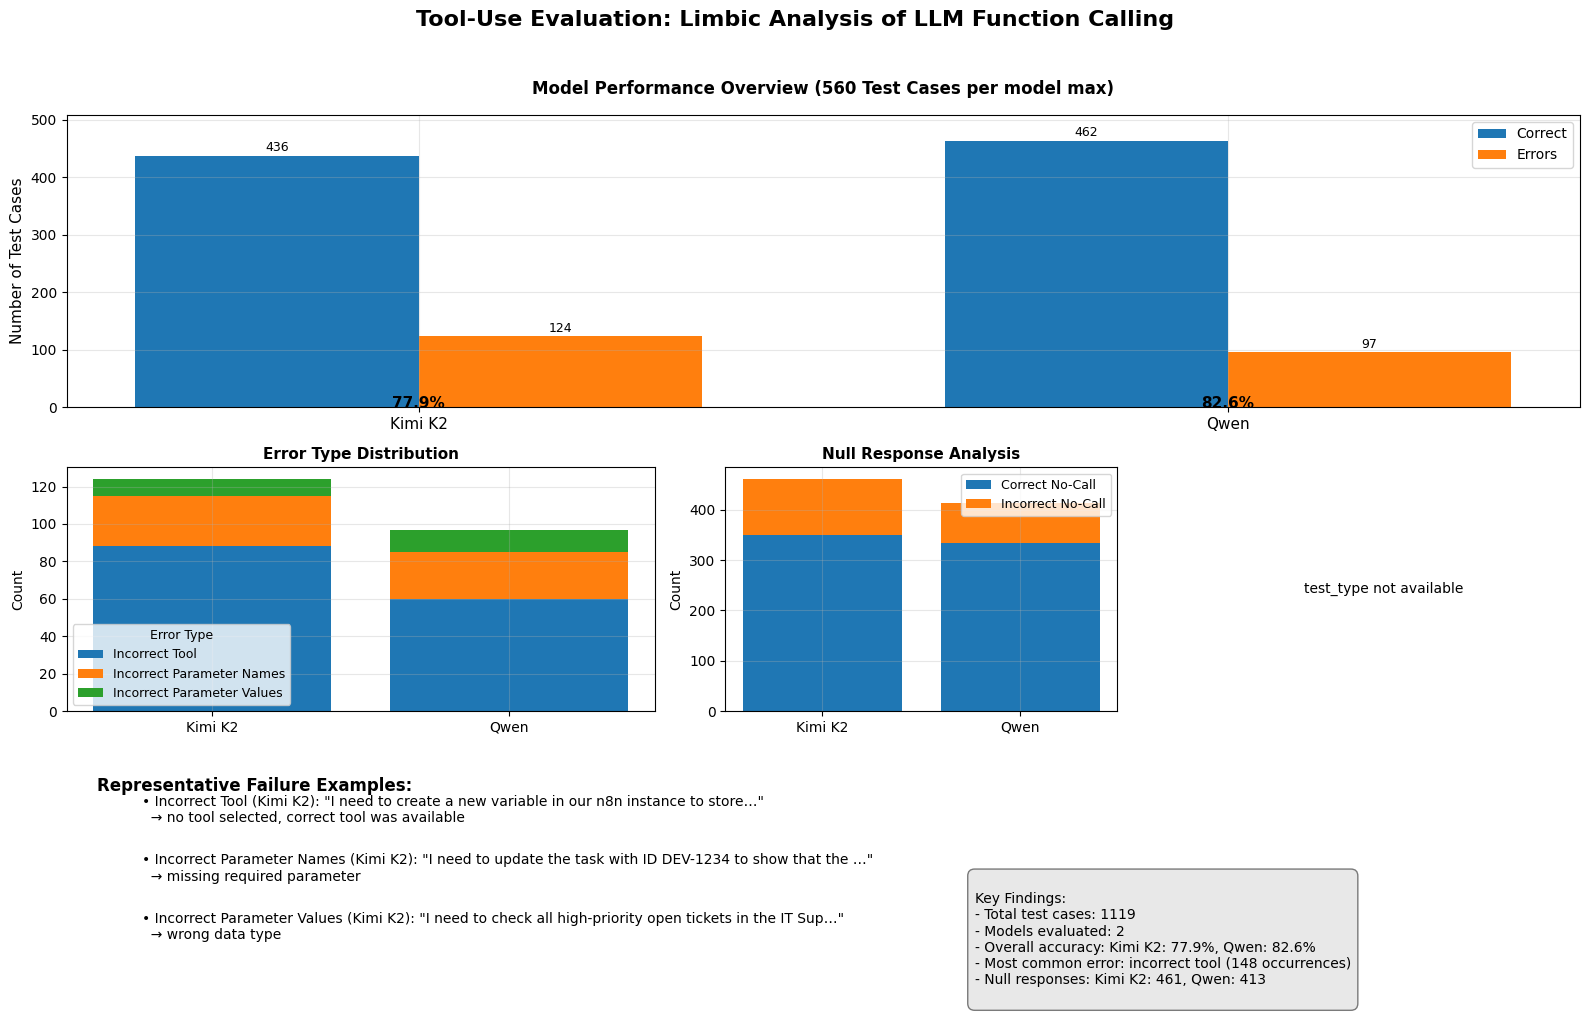

Saved figure: blog_evaluation_visualization_20250930_223448.png


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from datetime import datetime

results_df = pd.DataFrame(detailed_results).copy()

# Canonical label column (supports either limbic_label or string limbic_score)
score_categories = ["correct", "incorrect_tool", "incorrect_parameter_names", "incorrect_parameter_values"]

def coerce_label(row):
    # Priority: explicit label
    lab = row.get("limbic_label")
    if isinstance(lab, str) and lab in score_categories:
        return lab
    # Some evaluators stick the label into 'score' as a string
    sc = row.get("limbic_score")
    if isinstance(sc, str) and sc in score_categories:
        return sc
    return None

results_df["label"] = results_df.apply(coerce_label, axis=1)

# Numeric score for possible averages
def coerce_num(x):
    try:
        return float(x)
    except Exception:
        return np.nan

results_df["score_num"] = results_df["limbic_score"].apply(coerce_num)

# Figure style
plt.rcParams.update({
    "figure.figsize": (16, 10),
    "axes.grid": True,
    "grid.alpha": 0.3
})

fig = plt.figure(figsize=(16, 10))
fig.suptitle('Tool-Use Evaluation: Limbic Analysis of LLM Function Calling',
             fontsize=16, fontweight='bold', y=1.02)
gs = fig.add_gridspec(3, 3, height_ratios=[1.2, 1, 1], width_ratios=[1.5, 1, 1])

# 1) Overall Performance
ax1 = fig.add_subplot(gs[0, :])

models = list(results_df['model'].dropna().unique())
models_data = []
for model in models:
    mdf = results_df[results_df['model'] == model]
    total = len(mdf)
    correct = (mdf['label'] == 'correct').sum()
    models_data.append({
        'Model': model,
        'Correct': correct,
        'Errors': total - correct,
        'Total': total,
        'Accuracy': (correct / total * 100.0) if total else 0.0
    })

perf_df = pd.DataFrame(models_data)
x = np.arange(len(perf_df))
width = 0.35

bars1 = ax1.bar(x - width/2, perf_df['Correct'], width, label='Correct')
bars2 = ax1.bar(x + width/2, perf_df['Errors'], width, label='Errors')

# Value labels (compact; don’t print each case)
for bar in list(bars1) + list(bars2):
    h = bar.get_height()
    if h > 0:
        ax1.text(bar.get_x() + bar.get_width()/2., h + max(0.01*h, 0.5),
                 f'{int(h)}', ha='center', va='bottom', fontsize=9)

for i, row in perf_df.reset_index().iterrows():
    ax1.text(i, -0.5, f'{row["Accuracy"]:.1f}%', ha='center',
             fontweight='bold', fontsize=11)

ax1.set_ylabel('Number of Test Cases', fontsize=11)
ax1.set_title(f'Model Performance Overview ({int(perf_df["Total"].max())} Test Cases per model max)',
              fontsize=12, fontweight='bold', pad=15)
ax1.set_xticks(x)
ax1.set_xticklabels(perf_df['Model'], fontsize=11)
ax1.legend(loc='upper right', fontsize=10)
ax1.set_ylim(0, max(1.1*perf_df[['Correct','Errors']].to_numpy().max(), 5))

# 2) Error Type Distribution
ax2 = fig.add_subplot(gs[1, 0])
errors_df = results_df[results_df['label'].notna() & (results_df['label'] != 'correct')]

if not errors_df.empty:
    err = (errors_df
           .groupby(['model', 'label'])
           .size()
           .unstack(fill_value=0)
           .reindex(columns=[c for c in score_categories if c != 'correct'], fill_value=0))
    # simple stacked bars
    bottoms = np.zeros(len(err))
    xticks = np.arange(len(err))
    for col in err.columns:
        ax2.bar(xticks, err[col].values, bottom=bottoms, label=col.replace('_',' ').title())
        bottoms += err[col].values
    ax2.set_title('Error Type Distribution', fontsize=11, fontweight='bold')
    ax2.set_xlabel('')
    ax2.set_ylabel('Count', fontsize=10)
    ax2.set_xticks(xticks)
    ax2.set_xticklabels(err.index, rotation=0)
    ax2.legend(fontsize=9, title='Error Type', title_fontsize=9)
else:
    ax2.text(0.5, 0.5, 'No errors found', ha='center', va='center')
    ax2.set_axis_off()

# 3) Null Response Analysis
ax3 = fig.add_subplot(gs[1, 1])
null_rows = results_df.copy()
null_rows['was_null_response'] = null_rows['was_null_response'].fillna(False)

null_piv = pd.DataFrame({
    'Correct No-Call': (null_rows['was_null_response'] & (null_rows['label'] == 'correct')).groupby(null_rows['model']).sum(),
    'Incorrect No-Call': (null_rows['was_null_response'] & (null_rows['label'] != 'correct')).groupby(null_rows['model']).sum(),
}).fillna(0)

if not null_piv.empty:
    xt = np.arange(len(null_piv))
    ax3.bar(xt, null_piv['Correct No-Call'], label='Correct No-Call')
    ax3.bar(xt, null_piv['Incorrect No-Call'], bottom=null_piv['Correct No-Call'], label='Incorrect No-Call')
    ax3.set_title('Null Response Analysis', fontsize=11, fontweight='bold')
    ax3.set_xlabel('')
    ax3.set_ylabel('Count', fontsize=10)
    ax3.set_xticks(xt)
    ax3.set_xticklabels(null_piv.index, rotation=0)
    ax3.legend(fontsize=9)
else:
    ax3.text(0.5, 0.5, 'No null responses', ha='center', va='center')
    ax3.set_axis_off()

# 4) Test Type Performance (success counts)
ax4 = fig.add_subplot(gs[1, 2])

# Some datasets may not have 'test_type'; handle gracefully
if 'test_type' in results_df.columns:
    succ = (results_df.assign(success=(results_df['label'] == 'correct').astype(int))
            .pivot_table(index='test_type', columns='model', values='success', aggfunc='sum')
            .fillna(0)
            .sort_index())

    if not succ.empty:
        # Plot as small multiples bars (heatmap optional; avoiding seaborn dependency)
        xt = np.arange(len(succ.columns))
        y_base = np.arange(len(succ.index))
        ax4.set_title('Success Count by Test Type', fontsize=11, fontweight='bold')
        ax4.set_xlabel('')
        ax4.set_ylabel('Test Type', fontsize=10)
        ax4.set_yticks(y_base)
        ax4.set_yticklabels(succ.index, fontsize=8)
        # Draw bars per model per row
        bar_h = 0.8 / max(1, len(succ.columns))
        for j, col in enumerate(succ.columns):
            ax4.barh(y_base + j*bar_h - 0.4 + bar_h/2, succ[col].values, height=bar_h, label=col)
        ax4.legend(fontsize=7)
    else:
        ax4.text(0.5, 0.5, 'No test_type data', ha='center', va='center')
        ax4.set_axis_off()
else:
    ax4.text(0.5, 0.5, 'test_type not available', ha='center', va='center')
    ax4.set_axis_off()

# 5) Representative Failure Examples (top 3)
ax5 = fig.add_subplot(gs[2, :])
ax5.axis('off')

if not errors_df.empty:
    ax5.text(0.02, 0.92, 'Representative Failure Examples:', fontsize=12, fontweight='bold')
    y = 0.80
    step = 0.24

    # Take one example per error type for diversity
    for k, error_type in enumerate([c for c in score_categories if c != 'correct']):
        ex = errors_df[errors_df['label'] == error_type].head(1)
        if ex.empty:
            continue
        ex = ex.iloc[0]
        # Reasoning may be string or list
        reason = ex.get('limbic_reasoning')
        if isinstance(reason, list):
            reason = reason[0] if reason else ''
        if not isinstance(reason, str):
            reason = str(reason) if reason is not None else ''
        reason = (reason[:220] + '…') if len(reason) > 220 else reason

        prompt = ex.get('user_prompt') or ''
        prompt = (prompt[:60] + '…') if len(prompt) > 60 else prompt

        text = f"• {error_type.replace('_',' ').title()} ({ex['model']}): \"{prompt}\"\n  → {reason}"
        ax5.text(0.05, y - k*step, text, fontsize=10, wrap=True)

# Summary box (dynamic)
total_cases = len(results_df)
n_models = results_df['model'].nunique()

acc_lines = []
for m in models:
    mdf = results_df[results_df['model'] == m]
    tot = len(mdf)
    cor = (mdf['label'] == 'correct').sum()
    acc = (cor / tot * 100.0) if tot else 0.0
    acc_lines.append(f"{m}: {acc:.1f}%")

most_common_error = (errors_df['label'].mode()[0].replace('_',' ')
                     if not errors_df.empty else 'None')
most_common_error_n = (errors_df['label'].value_counts().iloc[0]
                       if not errors_df.empty else 0)

null_kimi = results_df[(results_df['model']=='Kimi K2') & (results_df['was_null_response']==True)].shape[0]
null_qwen = results_df[(results_df['model']=='Qwen') & (results_df['was_null_response']==True)].shape[0]

summary_text = f"""
Key Findings:
- Total test cases: {total_cases}
- Models evaluated: {n_models}
- Overall accuracy: {', '.join(acc_lines)}
- Most common error: {most_common_error} ({most_common_error_n} occurrences)
- Null responses: Kimi K2: {null_kimi}, Qwen: {null_qwen}
"""
ax5.text(0.60, 0.06, summary_text, fontsize=10,
         bbox=dict(boxstyle="round,pad=0.5", facecolor="lightgray", alpha=0.5))

plt.tight_layout()
outpath = f'blog_evaluation_visualization_{datetime.now().strftime("%Y%m%d_%H%M%S")}.png'
plt.savefig(outpath, dpi=150, bbox_inches='tight')
plt.show()

print("Saved figure:", outpath)
